In [186]:
import pandas as pd 
from pandas.tseries.offsets import Week
import numpy as np
%matplotlib inline

In [2]:
dir_path = '../data'

# Weather Data

In [3]:
df_weather = pd.read_csv(f'{dir_path}/weather_data.csv', parse_dates=['DATE'])

Source: https://www.ncdc.noaa.gov/cdo-web/search

In [4]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18818 entries, 0 to 18817
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   STATION  18818 non-null  object        
 1   NAME     18818 non-null  object        
 2   DATE     18818 non-null  datetime64[ns]
 3   PRCP     18606 non-null  float64       
 4   SNOW     8589 non-null   float64       
 5   TAVG     642 non-null    float64       
 6   TMAX     2984 non-null   float64       
 7   TMIN     2987 non-null   float64       
 8   TOBS     1227 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 1.3+ MB


In [5]:
df_weather['ds'] = df_weather['DATE'].dt.date

In [6]:
df_weather_daily = df_weather.groupby('ds').agg(prcp_avg=('PRCP', 'mean'),
                               tmax_avg=('TMAX','mean')).reset_index()

In [7]:
df_weather_daily.head()

,ds,prcp_avg,tmax_avg
0,2020-03-01,0.000000,4.578571
1,2020-03-02,0.000000,10.714286
2,2020-03-03,1.401235,14.521429
3,2020-03-04,7.004706,14.121429
4,2020-03-05,0.160000,11.900000


In [8]:
df_weather_daily.to_pickle(f'{dir_path}/aggregated_daily_weather_data.pkl')

In [9]:
df_weather['ds_w'] = df_weather['ds'].apply(lambda x: x if x.weekday() == 6 else x + Week(weekday=6))

In [10]:
df_weather_weekly = df_weather.groupby('ds_w').agg(prcp_avg=('PRCP', 'mean'),
                               tmax_avg=('TMAX','mean')).reset_index()

In [11]:
df_weather_weekly.head()

,ds_w,prcp_avg,tmax_avg
0,2020-03-01,0.000000,4.578571
1,2020-03-08,2.140391,11.395876
2,2020-03-15,1.536380,15.935052
3,2020-03-22,4.477540,12.829897
4,2020-03-29,6.081647,11.139796


In [12]:
df_weather_weekly.to_pickle(f'{dir_path}/aggregated_weekly_weather_data.pkl')

# COVID Data

source: https://data.cityofnewyork.us/Health/COVID-19-Daily-Counts-of-Cases-Hospitalizations-an/rc75-m7u3

In [13]:
df_covid = pd.read_csv(f'{dir_path}/nyc_covid_data.csv', parse_dates=['DATE_OF_INTEREST'])

In [14]:
df_covid.sample().T

,44
DATE_OF_INTEREST,2020-04-13 00:00:00
CASE_COUNT,3311
probable_case_count,185
HOSPITALIZED_COUNT,1143
DEATH_COUNT,568
...,...
si_all_case_count_7day_avg,370
SI_HOSPITALIZED_COUNT_7DAY_AVG,56
SI_DEATH_COUNT_7DAY_AVG,26
si_all_death_count_7day_avg,33


In [15]:
df_covid['month'] = df_covid['DATE_OF_INTEREST'].dt.month
df_covid['year'] = df_covid['DATE_OF_INTEREST'].dt.year

#### We just need 2020 for our task

In [16]:
df_covid = df_covid[df_covid['year'] == 2020]

In [17]:
df_covid = df_covid[df_covid['month'].isin(range(3,10))]
df_covid.month.value_counts()

8    31
7    31
5    31
3    31
9    30
6    30
4    30
Name: month, dtype: int64

In [18]:
df_covid.groupby('month')['CASE_COUNT_7DAY_AVG'].mean()

month
3    1626.258065
4    3920.033333
5    1078.387097
6     375.566667
7     322.161290
8     243.677419
9     340.966667
Name: CASE_COUNT_7DAY_AVG, dtype: float64

In [19]:
df_covid['ds'] = df_covid['DATE_OF_INTEREST'].dt.date

In [20]:
df_covid[['ds', 'CASE_COUNT_7DAY_AVG']].to_pickle(f'{dir_path}/covid_daily_processed.pkl')

### Weekly 

In [21]:
df_covid['ds_w'] = df_covid['ds'].apply(lambda x: x if x.weekday() == 6 else x + Week(weekday=6))

In [22]:
df_covid_weekly = df_covid.groupby('ds_w').agg(CASE_COUNT_7DAY_AVG=('CASE_COUNT_7DAY_AVG', 'mean')).reset_index()

In [23]:
df_covid_weekly.to_pickle(f'{dir_path}/covid_weekly_processed.pkl')

# COVID 19 Regulation

https://www.investopedia.com/historical-timeline-of-covid-19-in-new-york-city-5071986

In [102]:
cols = ['status_title', 'code']
reg_map = [
    ['closed', -1],
    ['reopening', 0],
    ['open', 1]
    ]
df_reg_map = pd.DataFrame(reg_map, columns=cols)

In [103]:
df_reg_map

,status_title,code
0,closed,-1
1,reopening,0
2,open,1


In [104]:
df_covid_reg = pd.DataFrame({'ds': pd.date_range('2020-03-01', '2020-10-01')})

In [105]:
df_covid_reg['regulation_status'] = 0

df_covid_reg.loc[df_covid_reg['ds'] < pd.to_datetime('2020-03-13') , 'regulation_status'] = 1
df_covid_reg.loc[df_covid_reg['ds'] > pd.to_datetime('2020-03-13') , 'regulation_status'] = -1
df_covid_reg.loc[df_covid_reg['ds'] > pd.to_datetime('2020-06-08') , 'regulation_status'] = 0

In [106]:
# sanity check

In [107]:
df_covid_reg['regulation_status'].value_counts()

 0    116
-1     87
 1     12
Name: regulation_status, dtype: int64

In [108]:
df_covid_reg = df_covid_reg.merge(df_reg_map, left_on='regulation_status', right_on='code')

In [109]:
df_covid_reg['ds'] = df_covid_reg['ds'].dt.date

In [110]:
df_covid_reg[['ds','regulation_status', 'status_title']].to_pickle(f'{dir_path}/reg_daily.pkl')

In [111]:
df_covid_reg.shape

(215, 4)

In [192]:
df_mobility = pd.read_csv(f'{dir_path}/2020_US_Region_Mobility_Report.csv', parse_dates=['date'])

In [193]:
df_mobility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812065 entries, 0 to 812064
Data columns (total 15 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   country_region_code                                 812065 non-null  object        
 1   country_region                                      812065 non-null  object        
 2   sub_region_1                                        811744 non-null  object        
 3   sub_region_2                                        795373 non-null  object        
 4   metro_area                                          0 non-null       float64       
 5   iso_3166_2_code                                     16371 non-null   object        
 6   census_fips_code                                    795694 non-null  float64       
 7   place_id                                            812065 non-null  object        

### Keeping NY within the needed timeframe

In [194]:
df_mobility = df_mobility[df_mobility['sub_region_1'] == 'New York']
df_mobility = df_mobility[df_mobility['date'].isin(pd.date_range('2020-02-01', '2020-10-01'))]
df_mobility['ds'] = df_mobility['date'].dt.date


### Retal and recreation mobility

In [195]:
agg_rm = df_mobility.groupby('ds').agg(retail_mobility=('retail_and_recreation_percent_change_from_baseline','mean')).reset_index()

### Workplace mobility

In [196]:
agg_wm = df_mobility.groupby('ds').agg(workplaces_mobility=('workplaces_percent_change_from_baseline','mean')).reset_index()

### Transit mobility

https://www.google.com/covid19/mobility/

In [197]:
agg_tm = df_mobility.groupby('ds').agg(transit_mobility=('transit_stations_percent_change_from_baseline','mean')).reset_index()

In [203]:
agg_re = df_mobility.groupby('ds').agg(residential_mobility=('residential_percent_change_from_baseline','mean')).reset_index()

In [207]:
agg_gr = df_mobility.groupby('ds').agg(grocery_mobility=('grocery_and_pharmacy_percent_change_from_baseline','mean')).reset_index()

In [211]:
df_mobility_data = agg_rm.merge(agg_wm).merge(agg_tm).merge(agg_re).merge(agg_gr)

<AxesSubplot:xlabel='ds'>

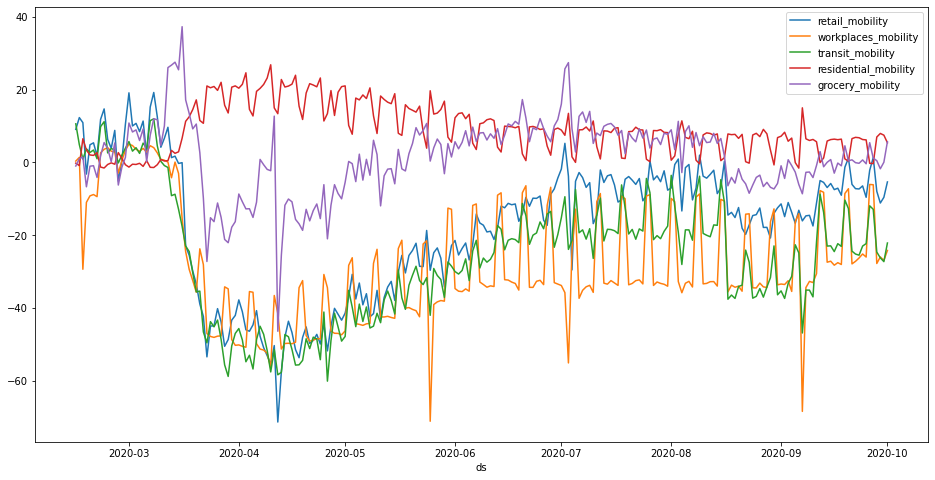

In [212]:
df_mobility_data.plot(x='ds', y=['retail_mobility', 'workplaces_mobility', 'transit_mobility', 'residential_mobility', 'grocery_mobility'], figsize=(16,8))

In [213]:
df_mobility_data.to_pickle(f'{dir_path}/mobility.pkl')